# Analysis of Luminex serum metabolites

## Preparatory steps

In [1]:
## set figure options)
options(repr.plot.width = 6, repr.plot.height = 6)
## load library
library(tidyverse)
library(lme4)
library(metafor)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.1
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loading 'metafor' package (version 2.4-0). For an overview 
and introduction to the package please type: help(metafor).



## Read data

In [2]:
BXDlumnxmetabolites <- "../data/AgingBXD_Metabolites_Luminex2021_SR.csv"
luminex <- read.csv(BXDlumnxmetabolites)
names(luminex)
nrow(luminex)

[1] "Eartag"            "StrainNameCurrent" "DietCode"         
 [4] "Sex"               "AgeAtDeath"        "C.peptide"        
 [7] "Insulin"           "Leptin"            "GIP..total."      
[10] "IL.6"              "MCP.1.CCL.2"       "Secretin"         
[13] "PP"                "PYY"               "Resistin"         
[16] "TNF.alpha"         "HOMA.IR"           "BodyWeight"       
[19] "MeanLifespan"      "Plate"

[1] 614

## Apply log transform

In [3]:
luminex <- mutate(luminex,
                  LogInsulin = log(Insulin),
                  LogLeptin = log(Leptin),
                  LogC.peptide = log(C.peptide),
                  LogHOMA.IR = log(HOMA.IR+1))

## T tests for serum hormones (luminex)

In [4]:
t.test(LogInsulin~DietCode,data=luminex)
t.test(LogLeptin~DietCode, data=luminex)
t.test(LogC.peptide~DietCode, data=luminex)
t.test(LogHOMA.IR~DietCode, data=luminex)


	Welch Two Sample t-test

data:  LogInsulin by DietCode
t = -7.937, df = 588.87, p-value = 1.051e-14
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.6676651 -0.4027827
sample estimates:
mean in group CD mean in group HF 
        7.028034         7.563258 



	Welch Two Sample t-test

data:  LogLeptin by DietCode
t = -11.23, df = 539.75, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.529391 -1.074002
sample estimates:
mean in group CD mean in group HF 
        7.520423         8.822120 



	Welch Two Sample t-test

data:  LogC.peptide by DietCode
t = -7.6324, df = 600.38, p-value = 9.1e-14
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.7776620 -0.4593604
sample estimates:
mean in group CD mean in group HF 
        5.941121         6.559632 



	Welch Two Sample t-test

data:  LogHOMA.IR by DietCode
t = -8.7501, df = 523.63, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.7883067 -0.4992370
sample estimates:
mean in group CD mean in group HF 
        2.195182         2.838954 


## Plotting serum hormone levels on each diet

Loading required package: sm

Package 'sm', version 2.2-5.6: type help(sm) for summary information

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




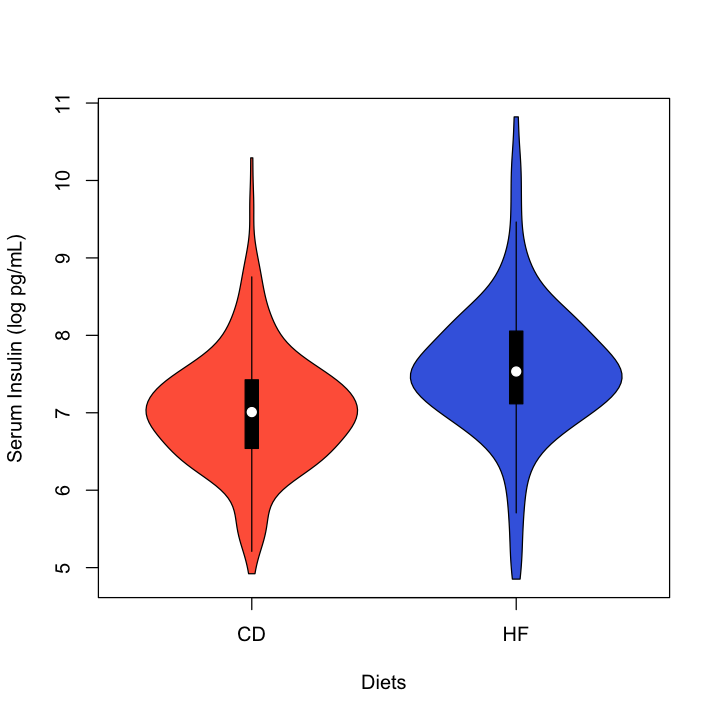

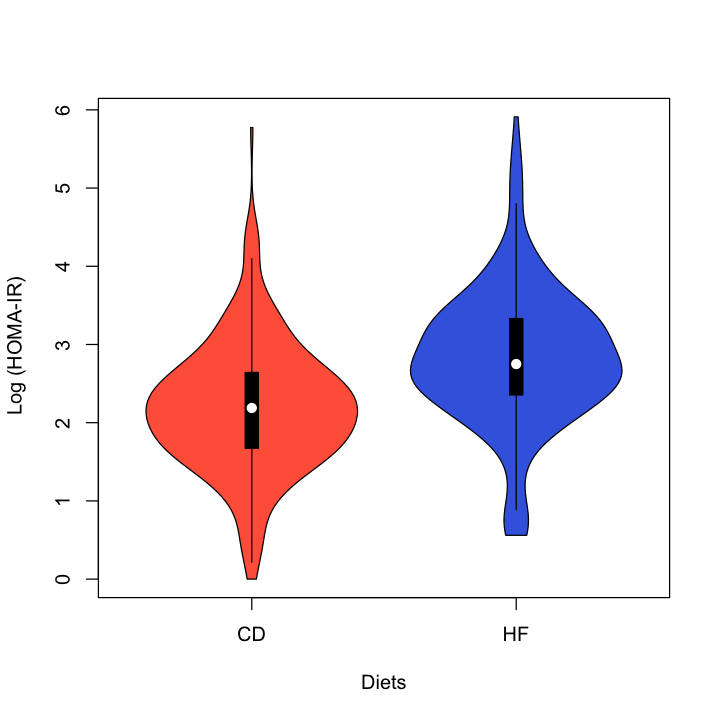

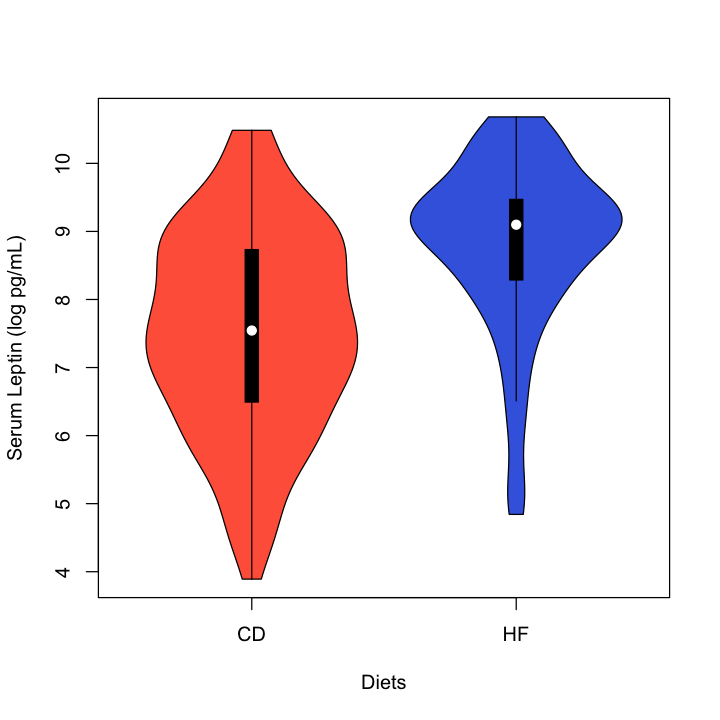

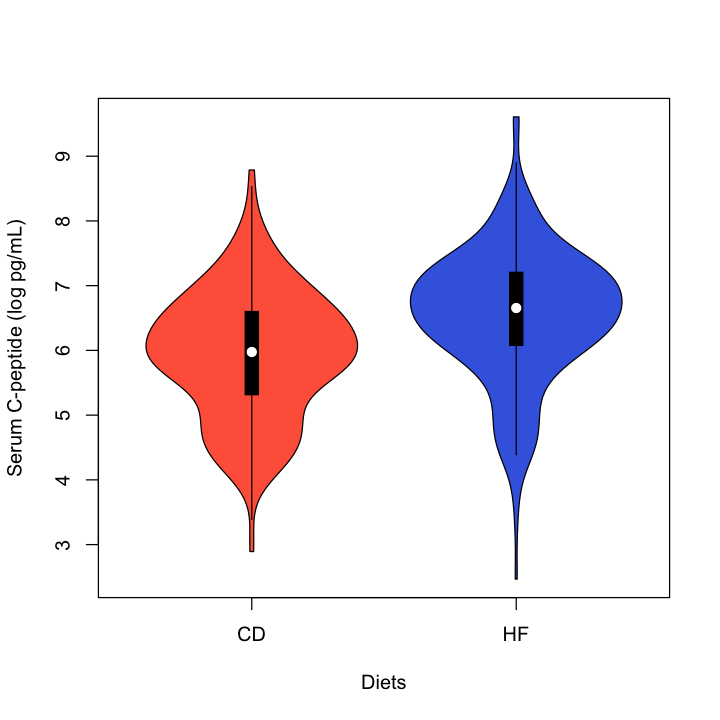

In [5]:
library(vioplot)
mycolors<- c("#E30613","#312783")
# pdf(file= "vioplot_logInsulin.pdf")
vioplot(luminex$LogInsulin ~luminex$DietCode,col= c("tomato", "royalblue"), xlab= "Diets", ylab= "Serum Insulin (log pg/mL)")
mediang <- tapply(luminex$LogInsulin, luminex$DietCode, median,na.rm=T)
# dev.off()
# pdf(file= "vioplot_logHOMAIR.pdf")
vioplot(luminex$LogHOMA.IR ~luminex$DietCode,col= c("tomato", "royalblue"), xlab= "Diets", ylab= " Log (HOMA-IR)")
mediang <- tapply(luminex$LogHOMA.IR, luminex$DietCode, median,na.rm=T)
# dev.off()
# pdf(file= "vioplot_logLeptin.pdf")
vioplot(luminex$LogLeptin ~luminex$DietCode,col= c("tomato", "royalblue"), xlab= "Diets", ylab= "Serum Leptin (log pg/mL)")
mediang <- tapply(luminex$LogLeptin,luminex$DietCode, median,na.rm=T)
# dev.off()
# pdf(file= "vioplot_logCpeptide.pdf")
vioplot(luminex$LogC.peptide ~luminex$DietCode,col= c("tomato", "royalblue"), xlab= "Diets", ylab= "Serum C-peptide (log pg/mL)")
mediang <- tapply(luminex$LogC.peptide, luminex$DietCode, median,na.rm=T)
# dev.off()

## Effect of serum hormones on age at death and final body weight on each diet adjusting for strain effect and plate

In [6]:
summarizeByCovariate2 <- function(data,pheno,cov,backCov,nmin=3)
    {
    covname <- as.name(cov)

    byStrain <- group_by(data,StrainNameCurrent) %>%
          summarize(n=n())
    strainsWithnmin <- filter(byStrain,n>nmin) %>% select(StrainNameCurrent)
    newdata <- filter(data,StrainNameCurrent %in% strainsWithnmin$StrainNameCurrent) %>%
             mutate(StrainNameCurrent=fct_drop(fct_explicit_na((StrainNameCurrent))))
    
    # lm
    outLM <- lm(formula(paste(pheno,"~",cov,"+",backCov,"+StrainNameCurrent")),data=newdata)
    # lmm
    outLMM <- lmer(formula(paste(pheno,"~",cov,"+",backCov,"+(1|StrainNameCurrent)")),data=newdata)
    # meta analysis
    covLM <- function(df)
        {
        lm(formula(paste(pheno,"~",cov,"+",backCov)),data=df)
        }
    pheno <- as.name(pheno)
    strainByCov <- group_by(newdata,StrainNameCurrent) %>% 
                   nest() %>% 
                   mutate(lmresult=map(data,covLM)) %>%
                   mutate(beta=map(lmresult,broom::tidy)) %>% 
                   unnest(beta) %>%
                   filter(grepl(cov,term))
    outMeta <- rma.uni(yi=strainByCov$estimate,sei=strainByCov$std.error)
                   

   # outMeta <- rma.uni(measure="MD",m1i=mean_HF,m2i=mean_CD,
   #                   sd1i=sd_HF,sd2i=sd_CD,n1i=n_HF,n2i=n_CD,
   #                   data=strainByDiet)
    lmtab <- as_tibble(coef(summary(outLM)),rownames="coefname") %>% filter(!grepl("Strain",coefname))
    av <- anova(outLM)
    avpct <- round(1000*av[,2]/sum(av[,2]))/10
    names(avpct) <- rownames(av)
    lmmtab <- coef(summary(outLMM))
    metatab <- coef(summary(outMeta))
    rownames(metatab) <- cov
    
    cat("\n --- ANOVA --- \n")
    print(avpct)
    cat("\n --- LM --- \n")
    print(lmtab)
    cat("\n --- LMM --- \n")
    print(lmmtab)
    cat("\n --- Meta --- \n")
    print(metatab)
   list(outLM=outLM,outLMM=outLMM,outMeta=outMeta)
}


In [7]:
# Separate datasets by diet

luminexCD = filter(luminex,DietCode=="CD")
luminexHF = filter(luminex,DietCode=="HF")

In [8]:
outInsulinHFAge <- summarizeByCovariate2(luminexHF,"LogInsulin","AgeAtDeath","Plate",4)
outInsulinHFBW <- summarizeByCovariate2(luminexHF,"LogInsulin","BodyWeight","Plate",4)
outLeptinHFAge <- summarizeByCovariate2(luminexHF,"LogLeptin","AgeAtDeath","Plate",6)
outLeptinHFBW <- summarizeByCovariate2(luminexHF,"LogC.peptide","BodyWeight","Plate",4)
outCpeptideHFAge <- summarizeByCovariate2(luminexHF,"LogC.peptide","AgeAtDeath","Plate",4)
outCpeptideHFBW <- summarizeByCovariate2(luminexHF,"LogLeptin","BodyWeight","Plate",6)
outHOMAIRHFAge <- summarizeByCovariate2(luminexHF,"LogHOMA.IR","AgeAtDeath","Plate",4)
outHOMAIRHFBW <- summarizeByCovariate2(luminexHF,"LogHOMA.IR","BodyWeight","Plate",4)

`summarise()` ungrouping output (override with `.groups` argument)




 --- ANOVA --- 
       AgeAtDeath             Plate StrainNameCurrent         Residuals 
              0.7               3.4              36.2              59.8 

 --- LM --- 
# A tibble: 3 x 5
  coefname     Estimate `Std. Error` `t value` `Pr(>|t|)`
  <chr>           <dbl>        <dbl>     <dbl>      <dbl>
1 (Intercept)  7.55         0.317       23.8     3.06e-62
2 AgeAtDeath   0.000278     0.000333     0.834   4.05e- 1
3 Plate       -0.0364       0.0266      -1.37    1.73e- 1

 --- LMM --- 
                 Estimate   Std. Error   t value
(Intercept)  7.6191012019 0.1981722001 38.446872
AgeAtDeath   0.0003246169 0.0003227752  1.005706
Plate       -0.0498876342 0.0253632939 -1.966923

 --- Meta --- 
               estimate           se     zval      pval         ci.lb
AgeAtDeath 0.0008142925 0.0007308625 1.114153 0.2652136 -0.0006181716
                 ci.ub
AgeAtDeath 0.002246757


`summarise()` ungrouping output (override with `.groups` argument)

Warning message in rma.uni(yi = strainByCov$estimate, sei = strainByCov$std.error):
“Studies with NAs omitted from model fitting.”



 --- ANOVA --- 
       BodyWeight             Plate StrainNameCurrent         Residuals 
             27.0               1.4              27.0              44.6 

 --- LM --- 
# A tibble: 3 x 5
  coefname    Estimate `Std. Error` `t value` `Pr(>|t|)`
  <chr>          <dbl>        <dbl>     <dbl>      <dbl>
1 (Intercept)   5.72        0.347      16.5     1.05e-38
2 BodyWeight    0.0294      0.00369     7.98    1.31e-13
3 Plate        -0.0193      0.0249     -0.776   4.39e- 1

 --- LMM --- 
               Estimate  Std. Error   t value
(Intercept)  6.35306258 0.204228873 31.107563
BodyWeight   0.02990340 0.003423625  8.734425
Plate       -0.03071529 0.023952944 -1.282318

 --- Meta --- 
             estimate          se    zval         pval      ci.lb      ci.ub
BodyWeight 0.02896987 0.008134086 3.56154 0.0003686865 0.01302735 0.04491238


`summarise()` ungrouping output (override with `.groups` argument)

Warning message in rma.uni(yi = strainByCov$estimate, sei = strainByCov$std.error):
“Studies with NAs omitted from model fitting.”



 --- ANOVA --- 
       AgeAtDeath             Plate StrainNameCurrent         Residuals 
              0.2               0.5              21.9              77.4 

 --- LM --- 
# A tibble: 3 x 5
  coefname     Estimate `Std. Error` `t value` `Pr(>|t|)`
  <chr>           <dbl>        <dbl>     <dbl>      <dbl>
1 (Intercept)  9.64         0.590       16.3     2.17e-32
2 AgeAtDeath  -0.000500     0.000623    -0.803   4.24e- 1
3 Plate       -0.0528       0.0521      -1.01    3.13e- 1

 --- LMM --- 
                 Estimate   Std. Error    t value
(Intercept)  9.2451520693 0.3234156949 28.5859722
AgeAtDeath  -0.0003468151 0.0005666533 -0.6120411
Plate       -0.0512614252 0.0478374910 -1.0715743

 --- Meta --- 
               estimate           se      zval      pval         ci.lb
AgeAtDeath 0.0006678004 0.0008458137 0.7895361 0.4297987 -0.0009899639
                 ci.ub
AgeAtDeath 0.002325565


`summarise()` ungrouping output (override with `.groups` argument)

Warning message in rma.uni(yi = strainByCov$estimate, sei = strainByCov$std.error):
“Studies with NAs omitted from model fitting.”



 --- ANOVA --- 
       BodyWeight             Plate StrainNameCurrent         Residuals 
             12.5               0.0              25.3              62.1 

 --- LM --- 
# A tibble: 3 x 5
  coefname    Estimate `Std. Error` `t value` `Pr(>|t|)`
  <chr>          <dbl>        <dbl>     <dbl>      <dbl>
1 (Intercept)   5.53        0.479       11.6    9.34e-24
2 BodyWeight    0.0190      0.00518      3.66   3.26e- 4
3 Plate         0.0459      0.0339       1.36   1.77e- 1

 --- LMM --- 
              Estimate  Std. Error    t value
(Intercept) 5.50735485 0.265733558 20.7251011
BodyWeight  0.02212559 0.004607945  4.8016175
Plate       0.02868557 0.031990871  0.8966798

 --- Meta --- 
             estimate        se     zval       pval       ci.lb      ci.ub
BodyWeight 0.01884312 0.0086709 2.173145 0.02976941 0.001848471 0.03583777


`summarise()` ungrouping output (override with `.groups` argument)




 --- ANOVA --- 
       AgeAtDeath             Plate StrainNameCurrent         Residuals 
              1.5               0.2              35.1              63.2 

 --- LM --- 
# A tibble: 3 x 5
  coefname     Estimate `Std. Error` `t value` `Pr(>|t|)`
  <chr>           <dbl>        <dbl>     <dbl>      <dbl>
1 (Intercept)  7.12         0.371       19.2     2.56e-48
2 AgeAtDeath  -0.000843     0.000389    -2.17    3.14e- 2
3 Plate        0.0281       0.0313       0.897   3.71e- 1

 --- LMM --- 
                 Estimate   Std. Error    t value
(Intercept)  6.8846595879 0.2265787656 30.3852816
AgeAtDeath  -0.0008135705 0.0003761237 -2.1630400
Plate        0.0095269707 0.0296640339  0.3211623

 --- Meta --- 
              estimate          se      zval      pval        ci.lb      ci.ub
AgeAtDeath 0.003639429 0.004629233 0.7861841 0.4317596 -0.005433701 0.01271256


`summarise()` ungrouping output (override with `.groups` argument)

Warning message:
“Problem with `mutate()` input `beta`.
✖ essentially perfect fit: summary may be unreliable
ℹ Input `beta` is `map(lmresult, broom::tidy)`.
ℹ The error occurred in group 6: StrainNameCurrent = "BXD34".”
Warning message in summary.lm(x):
“essentially perfect fit: summary may be unreliable”
Warning message in rma.uni(yi = strainByCov$estimate, sei = strainByCov$std.error):
“Studies with NAs omitted from model fitting.”
Warning message in rma.uni(yi = strainByCov$estimate, sei = strainByCov$std.error):
“Ratio of largest to smallest sampling variance extremely large. May not be able to obtain stable results.”



 --- ANOVA --- 
       BodyWeight             Plate StrainNameCurrent         Residuals 
              6.4               1.5              13.8              78.4 

 --- LM --- 
# A tibble: 3 x 5
  coefname    Estimate `Std. Error` `t value` `Pr(>|t|)`
  <chr>          <dbl>        <dbl>     <dbl>      <dbl>
1 (Intercept)   8.24        0.768      10.7     8.44e-19
2 BodyWeight    0.0213      0.00954     2.24    2.74e- 2
3 Plate        -0.0504      0.0569     -0.886   3.78e- 1

 --- LMM --- 
               Estimate  Std. Error   t value
(Intercept)  8.23888858 0.365266253 22.555844
BodyWeight   0.02257556 0.007432744  3.037312
Plate       -0.07122090 0.051163631 -1.392022

 --- Meta --- 
             estimate        se     zval       pval       ci.lb      ci.ub
BodyWeight 0.04078246 0.0164987 2.471859 0.01344124 0.008445608 0.07311932


`summarise()` ungrouping output (override with `.groups` argument)

Warning message in rma.uni(yi = strainByCov$estimate, sei = strainByCov$std.error):
“Studies with NAs omitted from model fitting.”



 --- ANOVA --- 
       AgeAtDeath             Plate StrainNameCurrent         Residuals 
              0.0               1.0              31.2              67.8 

 --- LM --- 
# A tibble: 3 x 5
  coefname      Estimate `Std. Error` `t value` `Pr(>|t|)`
  <chr>            <dbl>        <dbl>     <dbl>      <dbl>
1 (Intercept)  2.76          0.372       7.43     3.71e-12
2 AgeAtDeath   0.0000140     0.000387    0.0362   9.71e- 1
3 Plate       -0.0281        0.0301     -0.934    3.52e- 1

 --- LMM --- 
                 Estimate   Std. Error    t value
(Intercept)  2.991861e+00 0.2034525363 14.7054475
AgeAtDeath  -4.458556e-05 0.0003605835 -0.1236484
Plate       -3.536819e-02 0.0286281611 -1.2354334

 --- Meta --- 
              estimate         se     zval       pval         ci.lb       ci.ub
AgeAtDeath 0.002171997 0.00127425 1.704529 0.08828225 -0.0003254878 0.004669482


`summarise()` ungrouping output (override with `.groups` argument)

Warning message in rma.uni(yi = strainByCov$estimate, sei = strainByCov$std.error):
“Studies with NAs omitted from model fitting.”



 --- ANOVA --- 
       BodyWeight             Plate StrainNameCurrent         Residuals 
             27.7               0.5              21.5              50.4 

 --- LM --- 
# A tibble: 3 x 5
  coefname    Estimate `Std. Error` `t value` `Pr(>|t|)`
  <chr>          <dbl>        <dbl>     <dbl>      <dbl>
1 (Intercept)   0.867       0.360       2.41    1.71e- 2
2 BodyWeight    0.0309      0.00383     8.09    7.21e-14
3 Plate        -0.0135      0.0259     -0.522   6.02e- 1

 --- LMM --- 
               Estimate  Std. Error    t value
(Intercept)  1.51497946 0.200185068  7.5678944
BodyWeight   0.03059899 0.003448803  8.8723502
Plate       -0.02102470 0.024589720 -0.8550201

 --- Meta --- 
             estimate          se     zval         pval      ci.lb      ci.ub
BodyWeight 0.02734369 0.007700126 3.551071 0.0003836672 0.01225172 0.04243566
